# Assignment 1 - mkecera3@gatech.edu

## Import libraries

In [161]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import torch.nn.functional as F
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import preprocessing
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb

In [2]:
# structure to save accuracy results
allAccuracy = []

## Load and save the datasets

Start of citation - the following code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('./data', download=False, train=True, transform=transform)
testset = datasets.MNIST('./data', download=False, train=False, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

## Neural network

### MNIST dataset

In [4]:
def nnPredict(model, valloader, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    for images,labels in valloader:
        images = images.view(images.shape[0], -1)
        with torch.no_grad():
                output = model(images)
                loss = criterion(output, labels)
                running_loss += loss.item()
        
#         print(images.shape)
#         print(labels.shape)

        for i in range(len(labels)):
            img = images[i].view(1, 784)
#             print(img.shape)
            with torch.no_grad():
                logps = model(img)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader)))
    
    return running_loss/len(valloader), correct_count, all_count

In [5]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
drop_out = 0.2

model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )

In [6]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [7]:
def trainNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    time0 = time()
    epochs = 30
    lossData = []
    accData = []
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
        
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
            
        testingLoss, correctCount, allCount = nnPredict(model, valloader, criterion)
        print("Testing Loss  =", (testingLoss))
        
        lossData.append([e, running_loss/len(trainloader), 'Training Error'])
        lossData.append([e, testingLoss, 'Testing Error'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData    
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [8]:
lossDataBaseline, accDataBaseline = trainNN(model)

Epoch 0 - Training loss: 0.6894285637894859
Testing Loss  = 0.3258921942988019
Epoch 1 - Training loss: 0.29324334221499043
Testing Loss  = 0.2575740619639682
Epoch 2 - Training loss: 0.23613397430276017
Testing Loss  = 0.20782770999487798
Epoch 3 - Training loss: 0.19442587611658493
Testing Loss  = 0.17914413143495087
Epoch 4 - Training loss: 0.16399741286168928
Testing Loss  = 0.18037686919330792
Epoch 5 - Training loss: 0.1426647112697668
Testing Loss  = 0.14207978188327164
Epoch 6 - Training loss: 0.12367853941276784
Testing Loss  = 0.13140483646635798
Epoch 7 - Training loss: 0.11073698199656613
Testing Loss  = 0.11672226098146599
Epoch 8 - Training loss: 0.09992409402938068
Testing Loss  = 0.11628118278399395
Epoch 9 - Training loss: 0.09023657107435147
Testing Loss  = 0.11067986544696198
Epoch 10 - Training loss: 0.08199624434980514
Testing Loss  = 0.10576370006106842
Epoch 11 - Training loss: 0.07368645956025213
Testing Loss  = 0.1080675874154564
Epoch 12 - Training loss: 0.068

In [9]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]

In [10]:
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

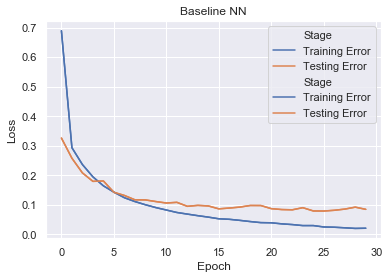

In [11]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig("NN_MNIST_baseline_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 Baseline NN')

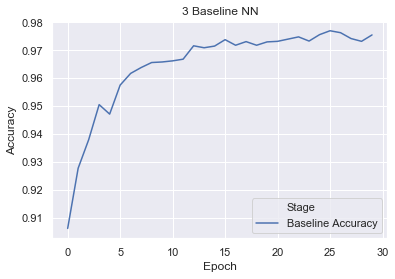

In [12]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('3 Baseline NN')

In [13]:
testingLoss, correctCount, allCount = nnPredict(model, testloader, criterion)

In [14]:
correctCount / allCount

0.9766

In [15]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_complex = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [16]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_complex(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [17]:
lossDataComplex, accDataComplex = trainNN(model_complex)

Epoch 0 - Training loss: 0.9489686108191909
Testing Loss  = 0.3723294643364894
Epoch 1 - Training loss: 0.3214370874340272
Testing Loss  = 0.26241457984325994
Epoch 2 - Training loss: 0.2344404409051208
Testing Loss  = 0.19531586690313496
Epoch 3 - Training loss: 0.18382063249597694
Testing Loss  = 0.16145906026718343
Epoch 4 - Training loss: 0.14886093693439995
Testing Loss  = 0.13672882115622614
Epoch 5 - Training loss: 0.1259470779753631
Testing Loss  = 0.12104623501966144
Epoch 6 - Training loss: 0.10539544411980169
Testing Loss  = 0.11155437816907267
Epoch 7 - Training loss: 0.09159168946530546
Testing Loss  = 0.10338703674044769
Epoch 8 - Training loss: 0.08232771070457309
Testing Loss  = 0.09838777519525237
Epoch 9 - Training loss: 0.07339683481339661
Testing Loss  = 0.09568135853216148
Epoch 10 - Training loss: 0.06427696019457534
Testing Loss  = 0.08934019379033024
Epoch 11 - Training loss: 0.05721440509020034
Testing Loss  = 0.09149157335228364
Epoch 12 - Training loss: 0.054

In [18]:
accDataComplex = [[row[0], row[1], 'More nodes and layers Accuracy'] for row in accDataComplex]

In [19]:
lossDataComplex = pd.DataFrame.from_records(lossDataComplex, columns=["Epoch", "Loss", "Stage"])
accDataComplex = pd.DataFrame.from_records(accDataComplex, columns=["Epoch", "Accuracy", "Stage"])

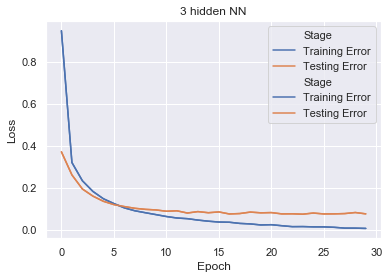

In [20]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataComplex
#     ).set_title('3 hidden NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataComplex
    ).set_title('3 hidden NN')
sns_plot.get_figure().savefig("NN_MNIST_3hidden_learning-curve.png", dpi=100)

Text(0.5, 1.0, '3 hidden NN')

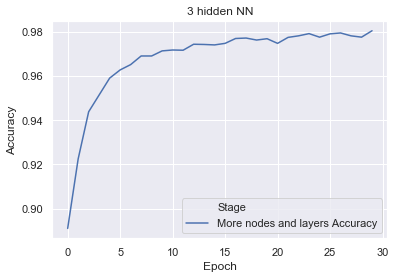

In [21]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataComplex
    ).set_title('3 hidden NN')

End of citation - the preceding code was addapted from https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627





In [22]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [23]:
correctCount / allCount

0.9787

In [24]:
input_size = 784
hidden_sizes = [256, 128, 64]
output_size = 10
drop_out = 0.2

model_dropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    # nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], output_size),
    nn.LogSoftmax(dim=1)
    )

In [25]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model_dropout(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [26]:
lossDataDropout, accDataDropout = trainNN(model_dropout)

Epoch 0 - Training loss: 1.0313696260647396
Testing Loss  = 0.37944539679083855
Epoch 1 - Training loss: 0.324705562361366
Testing Loss  = 0.2656055862072167
Epoch 2 - Training loss: 0.23240842500611034
Testing Loss  = 0.20828245461556563
Epoch 3 - Training loss: 0.18531664316077975
Testing Loss  = 0.17183591382708518
Epoch 4 - Training loss: 0.15582589018861276
Testing Loss  = 0.1479371953340378
Epoch 5 - Training loss: 0.13704821415950574
Testing Loss  = 0.14539929262249712
Epoch 6 - Training loss: 0.12055670054119719
Testing Loss  = 0.12518400433147028
Epoch 7 - Training loss: 0.10793257509822697
Testing Loss  = 0.1290981961402354
Epoch 8 - Training loss: 0.09952540733301274
Testing Loss  = 0.12460301970102035
Epoch 9 - Training loss: 0.09014015907333578
Testing Loss  = 0.12901297847556462
Epoch 10 - Training loss: 0.0852449950315487
Testing Loss  = 0.10199982589288692
Epoch 11 - Training loss: 0.07976463737378321
Testing Loss  = 0.1068818226610874
Epoch 12 - Training loss: 0.073304

In [27]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]

In [28]:
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

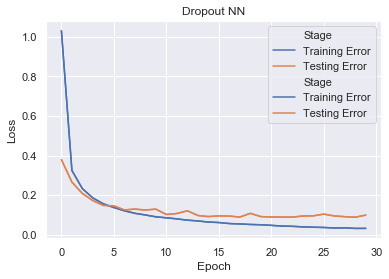

In [29]:
# vizualize train and test error across iterations
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataDropout
#     ).set_title('Dropout NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')
sns_plot.get_figure().savefig("NN_MNIST_dropout_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Dropout NN')

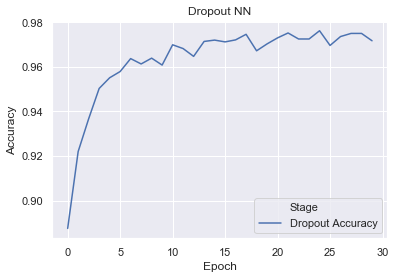

In [30]:
sns.set(
    style="darkgrid"
    )

sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [31]:
accData = accDataBaseline.copy()
accData = accData.append(accDataComplex)
accData = accData.append(accDataDropout)

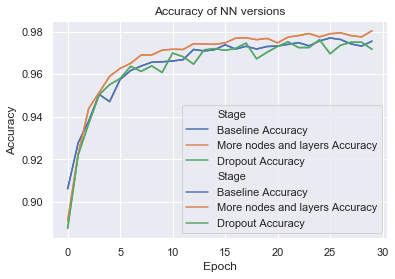

In [32]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Accuracy",
#     hue="Stage",
#     data=accData
#     ).set_title('Accuracy of NN versions')

sns_plot = sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')
sns_plot.get_figure().savefig("NN_MNIST_all_accuracy.png", dpi=100)

In [33]:
testingLoss, correctCount, allCount = nnPredict(model_complex, testloader, criterion)

In [34]:
correctCount / allCount

0.9787

In [35]:
allAccuracy.append(['Neural Network', 'MNIST', correctCount / allCount])

### Credit default dataset

In [36]:
# load dataset
creditDataDf = pd.read_excel('./data/default of credit card clients.xls', header=1)
creditDataDf = creditDataDf.drop(columns=['ID'])

In [37]:
print(sum(creditDataDf['default payment next month']))
print(len(creditDataDf))
print(sum(creditDataDf['default payment next month'])/len(creditDataDf))


6636
30000
0.2212


In [38]:
# create dummy variables from categorical
creditDataDf = pd.get_dummies(creditDataDf, prefix=['SEX', 'EDUCATION', 'MARRIAGE'], columns=['SEX', 'EDUCATION', 'MARRIAGE'])

In [39]:
# drop last mummy variable
creditDataDf = creditDataDf.drop(columns=['SEX_2', 'EDUCATION_6', 'MARRIAGE_3'])

In [40]:
y = creditDataDf['default payment next month']
creditDataDf = creditDataDf.drop(columns=['default payment next month'])

In [41]:
# balance the dataset
ros = RandomOverSampler(random_state=37)
creditDataDf, y = ros.fit_resample(creditDataDf, y)

In [42]:
print(sum(y)/len(y))

0.5


In [43]:
# normalize the data
x = creditDataDf.values #returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
creditDataDf = pd.DataFrame(x_scaled, columns=creditDataDf.columns)

In [44]:
creditDataDf

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_1,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2
0,-1.066767,-1.235239,1.389485,1.418888,-0.762035,-0.714663,-1.460706,-1.424029,-0.629750,-0.637715,...,-0.835849,-0.017312,-0.714064,1.044205,-0.455732,-0.054818,-0.084592,-0.039826,1.070811,-1.042550
1,-0.273358,-1.021606,-0.969669,1.418888,-0.017152,0.037336,0.082061,1.640659,-0.646504,-0.657066,...,-0.835849,-0.017312,-0.714064,1.044205,-0.455732,-0.054818,-0.084592,-0.039826,-0.933871,0.959187
2,-0.511381,-0.167072,-0.183284,-0.059380,-0.017152,0.037336,0.082061,0.108315,-0.285054,-0.484188,...,-0.835849,-0.017312,-0.714064,1.044205,-0.455732,-0.054818,-0.084592,-0.039826,-0.933871,0.959187
3,-0.828744,0.153379,-0.183284,-0.059380,-0.017152,0.037336,0.082061,0.108315,-0.043457,-0.003496,...,-0.835849,-0.017312,-0.714064,1.044205,-0.455732,-0.054818,-0.084592,-0.039826,1.070811,-1.042550
4,-0.828744,2.289714,-0.969669,-0.059380,-0.762035,0.037336,0.082061,0.108315,-0.565727,-0.601628,...,1.196388,-0.017312,-0.714064,1.044205,-0.455732,-0.054818,-0.084592,-0.039826,1.070811,-1.042550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46723,-0.194017,-0.807972,-0.183284,-0.059380,-0.017152,0.037336,0.082061,0.108315,0.953066,0.892599,...,-0.835849,-0.017312,-0.714064,1.044205,-0.455732,-0.054818,-0.084592,-0.039826,-0.933871,0.959187
46724,-0.511381,0.473829,-0.183284,-0.059380,-0.017152,0.037336,-0.689322,-0.657857,0.772579,0.318005,...,1.196388,-0.017312,-0.714064,1.044205,-0.455732,-0.054818,-0.084592,-0.039826,-0.933871,-1.042550
46725,-0.114676,-0.487522,1.389485,1.418888,-0.017152,0.037336,0.082061,0.108315,1.483271,1.496647,...,-0.835849,-0.017312,1.400434,-0.957666,-0.455732,-0.054818,-0.084592,-0.039826,1.070811,-1.042550
46726,-0.194017,0.794279,1.389485,2.158022,1.472614,1.541335,1.624828,1.640659,-0.415019,-0.413109,...,-0.835849,-0.017312,-0.714064,-0.957666,2.194273,-0.054818,-0.084592,-0.039826,1.070811,-1.042550


In [45]:
X_train, X_test, y_train, y_test = train_test_split(creditDataDf, y, test_size=0.2, random_state=37)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=37)

In [46]:
print(X_train.columns)
print(len(X_train.columns))

Index(['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_1', 'EDUCATION_0',
       'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2'],
      dtype='object')
30


In [47]:
sum(y_train)/len(y_train)

0.5023909045310149

In [48]:
# convert data to tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val.values.astype(np.float32))

y_train_tensor = torch.tensor(y_train.values.astype(np.int))
y_test_tensor = torch.tensor(y_test.values.astype(np.int))
y_val_tensor = torch.tensor(y_val.values.astype(np.int))

In [49]:
trainTorchDataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
valTorchDataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
testTorchDataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [50]:
print(len(valTorchDataset), len(testTorchDataset), len(trainTorchDataset))

7477 9346 29905


In [51]:
trainloader2 = torch.utils.data.DataLoader(trainTorchDataset, batch_size=64, shuffle=True)
valloader2 = torch.utils.data.DataLoader(valTorchDataset, batch_size=len(valTorchDataset), shuffle=True)
testloader2 = torch.utils.data.DataLoader(testTorchDataset, batch_size=len(testTorchDataset), shuffle=True)

In [52]:
def nnPredictTabular(model2, valloader2, criterion):
    correct_count, all_count = 0, 0
    running_loss = 0
    probList = []
    for rows,labels in valloader2:
        
#         print(rows.shape)
#         print(labels.shape)
        
        with torch.no_grad():
                output = model2(rows)
                loss = criterion(output, labels)
                running_loss += loss.item()


        for i in range(len(labels)):
            row = rows[i].view(1, 30)
#             print(row.shape)
            with torch.no_grad():
                logps = model2(row)

            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            probList.append(probab)
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

#     print("Number Of Images Tested =", all_count)
#     print("Model Accuracy =", (correct_count/all_count))
#     print("Testing Loss  =", (running_loss/len(valloader2)))
    
    return running_loss/len(valloader2), correct_count, all_count, probList

In [53]:
input_size = 30
hidden_sizes = [25, 15]
output_size = 2

modelTabBaseline = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [54]:
def trainTabNN(model):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    # optimizer = optim.Adam(model.parameters(), lr=0.01)
    time0 = time()
    epochs = 100
    lossData = []
    accData=[]
    for e in range(epochs):
        running_loss = 0
        for rows, labels in trainloader2:
                
            # Training pass
            optimizer.zero_grad()
            
            output = model(rows)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader2)))
            
        testingLoss, correctCount, allCount, proba = nnPredictTabular(model, valloader2, criterion)
        print("Testing Loss  =", (testingLoss))
        print("Testing Accuracy  =", (correctCount / allCount))
        
        lossData.append([e, running_loss/len(trainloader2), 'Training Loss'])
        lossData.append([e, testingLoss, 'Testing Loss'])
        accData.append([e, correctCount / allCount])
    
    return lossData, accData
        
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [55]:
lossDataBaseline, accDataBaseline = trainTabNN(modelTabBaseline)

Epoch 0 - Training loss: 0.664675670556533
Testing Loss  = 0.6306775212287903
Testing Accuracy  = 0.6417012170656681
Epoch 1 - Training loss: 0.6126556584340894
Testing Loss  = 0.5960662961006165
Testing Accuracy  = 0.6883776915875351
Epoch 2 - Training loss: 0.5933813880014623
Testing Loss  = 0.5829868316650391
Testing Accuracy  = 0.7045606526681825
Epoch 3 - Training loss: 0.5835557944881611
Testing Loss  = 0.5748663544654846
Testing Accuracy  = 0.7072355222682895
Epoch 4 - Training loss: 0.5782457041180032
Testing Loss  = 0.5706572532653809
Testing Accuracy  = 0.7077704961883108
Epoch 5 - Training loss: 0.5750340258336475
Testing Loss  = 0.5682713985443115
Testing Accuracy  = 0.7060318309482413
Epoch 6 - Training loss: 0.5726067006715343
Testing Loss  = 0.5671601891517639
Testing Accuracy  = 0.7073692657482947
Epoch 7 - Training loss: 0.5699890781289492
Testing Loss  = 0.5634944438934326
Testing Accuracy  = 0.7100441353484017
Epoch 8 - Training loss: 0.5682287047434057
Testing Loss 

In [56]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabBaseline, testloader2, criterion)

In [57]:
correctCount/allCount

0.7233040873100792

In [58]:
accDataBaseline = [[row[0], row[1], 'Baseline Accuracy'] for row in accDataBaseline]
lossDataBaseline = pd.DataFrame.from_records(lossDataBaseline, columns=["Epoch", "Loss", "Stage"])
accDataBaseline = pd.DataFrame.from_records(accDataBaseline, columns=["Epoch", "Accuracy", "Stage"])

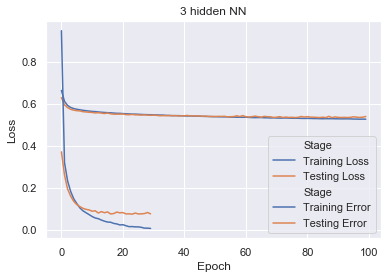

In [59]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataBaseline
#     ).set_title('Baseline NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataBaseline
    ).set_title('Baseline NN')
sns_plot.get_figure().savefig("NN_MNIST_3hidden_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Baseline NN')

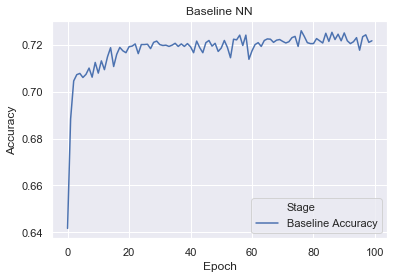

In [60]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataBaseline
    ).set_title('Baseline NN')

In [61]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2

modelTabLarge = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [62]:
lossDataLarge, accDataLarge = trainTabNN(modelTabLarge)

Epoch 0 - Training loss: 0.6932738285798293
Testing Loss  = 0.6930888295173645
Testing Accuracy  = 0.5048816370201953
Epoch 1 - Training loss: 0.6931574991625599
Testing Loss  = 0.6932396292686462
Testing Accuracy  = 0.4951183629798047
Epoch 2 - Training loss: 0.6931160321602454
Testing Loss  = 0.6931124329566956
Testing Accuracy  = 0.4952521064598101
Epoch 3 - Training loss: 0.6930685700514377
Testing Loss  = 0.6930511593818665
Testing Accuracy  = 0.49565333689982616
Epoch 4 - Training loss: 0.6930039262669718
Testing Loss  = 0.6930147409439087
Testing Accuracy  = 0.49551959341982077
Epoch 5 - Training loss: 0.6929653739063149
Testing Loss  = 0.692875325679779
Testing Accuracy  = 0.4987294369399492
Epoch 6 - Training loss: 0.6928399465022943
Testing Loss  = 0.6926791071891785
Testing Accuracy  = 0.5050153805002006
Epoch 7 - Training loss: 0.6927191398592076
Testing Loss  = 0.6925285458564758
Testing Accuracy  = 0.6105389862244216
Epoch 8 - Training loss: 0.6924652952669014
Testing Los

In [63]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, testloader2, criterion)

In [64]:
correctCount/allCount

0.7137812968114702

In [65]:
accDataLarge = [[row[0], row[1], '5 hidden Accuracy'] for row in accDataLarge]
lossDataLarge = pd.DataFrame.from_records(lossDataLarge, columns=["Epoch", "Loss", "Stage"])
accDataLarge = pd.DataFrame.from_records(accDataLarge, columns=["Epoch", "Accuracy", "Stage"])

In [66]:
accDataLarge

,Epoch,Accuracy,Stage
0,0,0.504882,5 hidden Accuracy
1,1,0.495118,5 hidden Accuracy
2,2,0.495252,5 hidden Accuracy
3,3,0.495653,5 hidden Accuracy
4,4,0.495520,5 hidden Accuracy
...,...,...,...
95,95,0.727966,5 hidden Accuracy
96,96,0.726093,5 hidden Accuracy
97,97,0.718871,5 hidden Accuracy
98,98,0.722884,5 hidden Accuracy


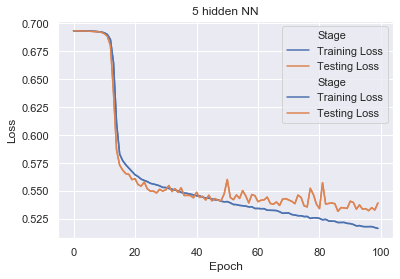

In [67]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataLarge
    # ).set_title('5 hidden NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataLarge
    ).set_title('5 hidden NN')
sns_plot.get_figure().savefig("NN_CREDIT_5hidden_learning-curve.png", dpi=100)

Text(0.5, 1.0, '5 hidden NN')

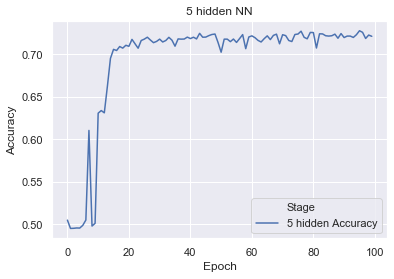

In [68]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataLarge
    ).set_title('5 hidden NN')

In [69]:
input_size = 30
hidden_sizes = [25, 20, 20, 20, 15, 15]
output_size = 2
drop_out = 0.2

modelTabDropout = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[1], hidden_sizes[2]),
    nn.ReLU(),
    nn.Dropout(drop_out, inplace=True),
    nn.Linear(hidden_sizes[2], hidden_sizes[3]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[3], hidden_sizes[4]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[4], hidden_sizes[5]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[5], output_size),
    nn.LogSoftmax(dim=1)
    )
criterion = nn.NLLLoss()

In [70]:
lossDataDropout, accDataDropout = trainTabNN(modelTabDropout)

Epoch 0 - Training loss: 0.6955039685862696
Testing Loss  = 0.6929398775100708
Testing Accuracy  = 0.5036779457001471
Epoch 1 - Training loss: 0.6929830936794608
Testing Loss  = 0.6929222345352173
Testing Accuracy  = 0.5535642637421426
Epoch 2 - Training loss: 0.6929216722392628
Testing Loss  = 0.6928586959838867
Testing Accuracy  = 0.500200615220008
Epoch 3 - Training loss: 0.6928073706535193
Testing Loss  = 0.6927032470703125
Testing Accuracy  = 0.5638625117025545
Epoch 4 - Training loss: 0.6926373401258745
Testing Loss  = 0.6925105452537537
Testing Accuracy  = 0.4952521064598101
Epoch 5 - Training loss: 0.6923500016713754
Testing Loss  = 0.692099928855896
Testing Accuracy  = 0.5867326467834693
Epoch 6 - Training loss: 0.6916425007785487
Testing Loss  = 0.6911656260490417
Testing Accuracy  = 0.5483482680219339
Epoch 7 - Training loss: 0.6903675384501107
Testing Loss  = 0.6892544031143188
Testing Accuracy  = 0.5641299986625652
Epoch 8 - Training loss: 0.6859501540406138
Testing Loss  

In [71]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabDropout, testloader2, criterion)

In [72]:
correctCount/allCount

0.720415150866681

In [73]:
accDataDropout = [[row[0], row[1], 'Dropout Accuracy'] for row in accDataDropout]
lossDataDropout = pd.DataFrame.from_records(lossDataDropout, columns=["Epoch", "Loss", "Stage"])
accDataDropout = pd.DataFrame.from_records(accDataDropout, columns=["Epoch", "Accuracy", "Stage"])

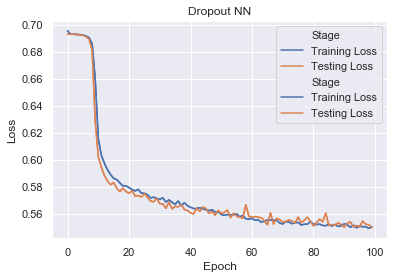

In [74]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Loss",
#     hue="Stage",
#     data=lossDataDropout
#     ).set_title('Dropout NN')

sns_plot = sns.lineplot(
    x="Epoch", y="Loss",
    hue="Stage",
    data=lossDataDropout
    ).set_title('Dropout NN')
sns_plot.get_figure().savefig("NN_CREDIT_dropout_learning-curve.png", dpi=100)

Text(0.5, 1.0, 'Dropout NN')

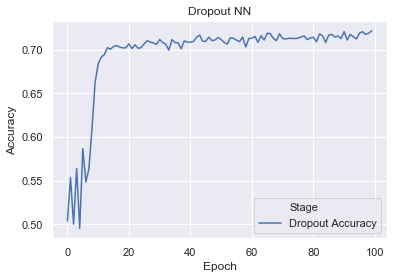

In [75]:
sns.set(
    style="darkgrid"
    )
    
sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accDataDropout
    ).set_title('Dropout NN')

In [76]:
accData = accDataBaseline.copy()
accData = accData.append(accDataLarge)
accData = accData.append(accDataDropout)

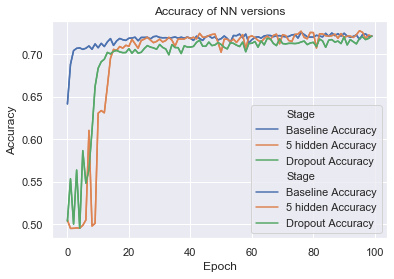

In [77]:
sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Epoch", y="Accuracy",
#     hue="Stage",
#     data=accData
#     ).set_title('Accuracy of NN versions')

sns_plot = sns.lineplot(
    x="Epoch", y="Accuracy",
    hue="Stage",
    data=accData
    ).set_title('Accuracy of NN versions')
sns_plot.get_figure().savefig("NN_CREDIT_all_accuracy.png", dpi=100)

In [78]:
testingLoss, correctCount, allCount, proba = nnPredictTabular(modelTabLarge, testloader2, criterion)

In [79]:
allAccuracy.append(['Neural Network', 'Credit', correctCount / allCount])

## Decision tree

### MNIST dataset

In [80]:
trainset = datasets.MNIST('./data', download=False, train=True, transform=transform)
testset = datasets.MNIST('./data', download=False, train=False, transform=transform)

In [81]:
X_train_MNIST = trainset.data.numpy()
X_test_MNIST = testset.data.numpy()

In [82]:
y_train_MNIST = trainset.targets.numpy()
y_test_MNIST = testset.targets.numpy()

In [83]:
np.bincount(y_train_MNIST) + np.bincount(y_test_MNIST)

array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958])

In [84]:
print(X_train_MNIST.shape)
print(y_train_MNIST.shape)

(60000, 28, 28)
(60000,)


In [85]:
X_train_MNIST_reshaped = X_train_MNIST.reshape((60000, 784))
X_test_MNIST_reshaped = X_test_MNIST.reshape((10000, 784))

In [86]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
gridSearchTree.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 16.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 

In [87]:
gridSearchTree.best_params_

{'max_depth': 15, 'min_samples_leaf': 5}

In [88]:
preds = gridSearchTree.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))

0.8808


In [89]:
allAccuracy.append(['Decision Tree', 'MNIST', accuracy_score(preds, y_test_MNIST)])

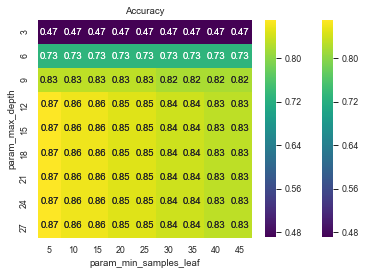

In [90]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot.get_figure().savefig("DT_MNIST_CV_accuracy.png", dpi=100)

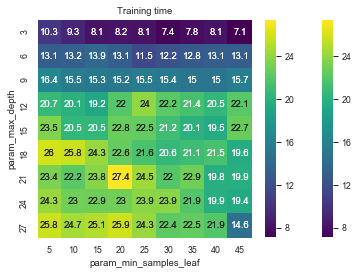

In [91]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 1)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig("DT_MNIST_CV_train-time.png", dpi=100)

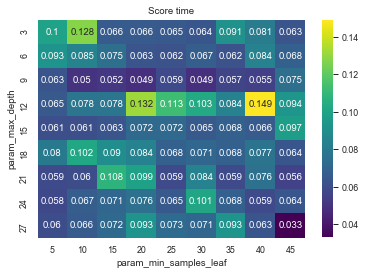

In [92]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
# sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig("DT_MNIST_CV_score-time.png", dpi=100)

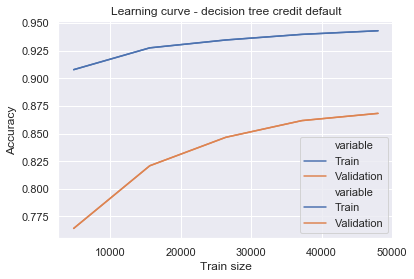

In [93]:
bestModel = tree.DecisionTreeClassifier(**gridSearchTree.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')
sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve - decision tree credit default')
sns_plot.get_figure().savefig("DT_MNIST_learning-curve.png", dpi=100)

### Credit default dataset

In [94]:
np.bincount(y_train) + np.bincount(y_test) + np.bincount(y_val)

array([23364, 23364])

In [95]:
# concatenate dfs
X_train = pd.concat([X_train,X_val], axis=0)
y_train = pd.concat([y_train,y_val], axis=0)
print(X_train.shape)
print(y_train.shape)

(37382, 30)
(37382,)


In [96]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'min_samples_leaf': np.arange(5, 50, 5) }
gridSearchTree = GridSearchCV(
    tree.DecisionTreeClassifier(), param_grid, n_jobs=-1, verbose=2, scoring='accuracy'
    )
gridSearchTree.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   27.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 3,  6,  9, 12, 15, 18, 21, 24, 

In [97]:
preds = gridSearchTree.predict(X_test)
probs = gridSearchTree.predict_proba(X_test)
print(accuracy_score(preds, y_test))

0.8038733147870747


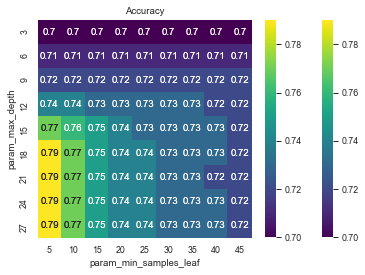

In [98]:
cvResultsScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_min_samples_leaf', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis').set_title('Accuracy')
sns_plot.get_figure().savefig("DT_CREDIT_accuracy.png", dpi=100)

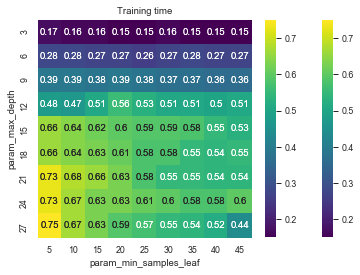

In [99]:
cvResultsTimeTrain = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_min_samples_leaf', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_fit_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

# sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig("DT_CREDIT_training-time.png", dpi=100)

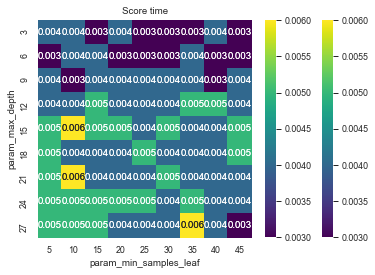

In [100]:
cvResultsTimeScore = pd.DataFrame(gridSearchTree.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_min_samples_leaf', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_min_samples_leaf', values='mean_score_time')
sns.set_context("paper")
sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

# sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig("DT_CREDIT_score-time.png", dpi=100)

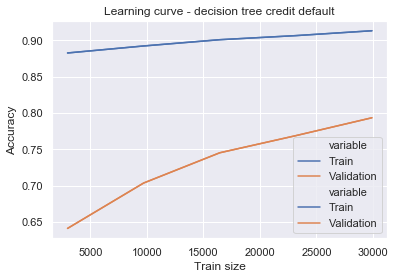

In [101]:
bestModel = tree.DecisionTreeClassifier(**gridSearchTree.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve - decision tree credit default')
sns_plot.get_figure().savefig("DT_CREDIT_learning-curve.png", dpi=100)

In [102]:
preds = gridSearchTree.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['Decision Tree', 'Credit', accuracy_score(preds, y_test)])

0.8038733147870747


In [103]:
print(allAccuracy)

[['Neural Network', 'MNIST', 0.9787], ['Neural Network', 'Credit', 0.7137812968114702], ['Decision Tree', 'MNIST', 0.8808], ['Decision Tree', 'Credit', 0.8038733147870747]]


## Boosting

### MNIST

In [202]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'n_estimators': np.arange(10, 100, 10) }
gridSearchBoosting = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3, tree_method='hist', nthread=8, subsample=0.5), param_grid, n_jobs=8, verbose=3, scoring='accuracy'
    )
gridSearchBoosting.fit(X_train_MNIST_reshaped, y_train_MNIST)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [0]:
gridSearchBoosting.best_params_

In [0]:
preds = gridSearchBoosting.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['Boosting', 'MNIST', accuracy_score(preds, y_test_MNIST)])

In [0]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResults[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig("BOOSTING_MNIST_accuracy.png", dpi=100)

In [0]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig("BOOSTING_MNIST_train-time", dpi=100)

In [0]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig("BOOSTING_MNIST_score-time.png", dpi=100)

In [0]:
bestModel = GradientBoostingClassifier(**gridSearchBoosting.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )

In [0]:
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve - decision tree credit default')
sns_plot.get_figure().savefig("BOOSTING_MNIST_learning-curve.png", dpi=100)

### Credit default

In [204]:
param_grid = {'max_depth': np.arange(3, 30, 3), 'n_estimators': np.arange(10, 100, 10) }
gridSearchBoosting = GridSearchCV(
    xgb.XGBClassifier(learning_rate=0.3, tree_method='hist', nthread=8), param_grid, n_jobs=8, verbose=1, scoring='accuracy'
    )
gridSearchBoosting.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.0s


KeyboardInterrupt: 

In [188]:
preds = gridSearchBoosting.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['Boosting', 'Credit', accuracy_score(preds, y_test)])
print(gridSearchBoosting.best_params_)

0.92574363364006
{'max_depth': 18, 'n_estimators': 80}


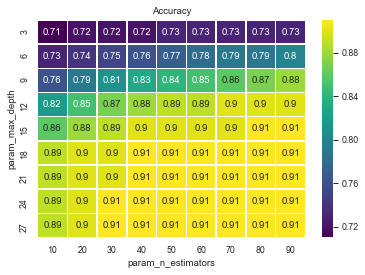

In [189]:
cvResultsScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsScore = cvResultsScore[['param_max_depth', 'param_n_estimators', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig("BOOSTING_CREDIT_accuracy.png", dpi=100)

In [0]:
cvResultsTimeTrain = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_max_depth', 'param_n_estimators', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis').set_title('Training time')
sns_plot.get_figure().savefig("BOOSTING_CREDIT_training-time.png", dpi=100)

In [0]:
cvResultsTimeScore = pd.DataFrame(gridSearchBoosting.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_max_depth', 'param_n_estimators', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 3)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis').set_title('Score time')
sns_plot.get_figure().savefig("BOOSTING_CREDIT_score-time.png", dpi=100)

In [177]:
bestModel = GradientBoostingClassifier(**gridSearchBoosting.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )

KeyboardInterrupt: 

In [0]:
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve - decision tree credit default')
sns_plot.get_figure().savefig("BOOSTING_CREDIT_learning-curve.png", dpi=100)

In [152]:
print(allAccuracy)

[['Neural Network', 'MNIST', 0.9787], ['Neural Network', 'Credit', 0.7137812968114702], ['Decision Tree', 'MNIST', 0.8808], ['Decision Tree', 'Credit', 0.8038733147870747], ['Boosting', 'Credit', 0.9293815536058206], ['Boosting', 'Credit', 0.9293815536058206]]


## KNN

### MNIST

In [ ]:
param_grid = {'n_neighbors': np.arange(3, 24, 3), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
kNN.fit(X_train_MNIST_reshaped, y_train_MNIST)

preds = kNN.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['KNN', 'MNIST', accuracy_score(preds, y_test_MNIST)])

In [ ]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResultsScore[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig("KNN_MNIST_accuracy.png", dpi=100)

In [ ]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_n_neighbors', columns='param_weights', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig("KNN_MNIST_training-time.png", dpi=100)

In [ ]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig("KNN_MNIST_score-time.png", dpi=100)

In [ ]:
bestModel = KNeighborsClassifier(**kNN.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve - decision tree credit default')
sns_plot.get_figure().savefig("KNN_MNIST_learning-curve.png", dpi=100)

### Credit default

In [ ]:
param_grid = {'n_neighbors': np.arange(3, 24, 3), 'weights': ['uniform', 'distance']}
kNN = GridSearchCV(
    KNeighborsClassifier(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
kNN.fit(X_train, y_train)

In [ ]:
preds = kNN.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['KNN', 'Credit', accuracy_score(preds, y_test)])

In [ ]:
cvResultsScore = pd.DataFrame(kNN.cv_results_)
cvResultsScore = cvResultsScore[['param_n_neighbors', 'param_weights', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig("KNN_CREDIT_accuracy.png", dpi=100)

In [ ]:
cvResultsTimeTrain = pd.DataFrame(kNN.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_n_neighbors', 'param_weights', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_n_neighbors', columns='param_weights', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig("KNN_CREDIT_training-time.png", dpi=100)

In [ ]:
cvResultsTimeScore = pd.DataFrame(kNN.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_n_neighbors', 'param_weights', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_n_neighbors', columns='param_weights', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig("KNN_CREDIT_score-time.png", dpi=100)

In [ ]:
bestModel = KNeighborsClassifier(**kNN.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve - decision tree credit default')
sns_plot.get_figure().savefig("KNN_CREDIT_learning-curve.png", dpi=100)

## SVM

### MNIST

In [ ]:
param_grid = {'kernel': ['poly', 'rbf', 'linear'], 'max_iter': np.arange(10, 100, 10)}
SVM = GridSearchCV(
    svm.SVC(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
SVM.fit(X_train_MNIST_reshaped, y_train_MNIST)

preds = SVM.predict(X_test_MNIST_reshaped)
print(accuracy_score(preds, y_test_MNIST))
allAccuracy.append(['SVM', 'MNIST', accuracy_score(preds, y_test_MNIST)])

In [ ]:
cvResultsScore = pd.DataFrame(SVM.cv_results_)
cvResultsScore = cvResultsScore[['param_kernel', 'param_max_iter', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig("SVM_MNIST_accuracy.png", dpi=100)

In [ ]:
cvResultsTimeTrain = pd.DataFrame(SVM.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_kernel', 'param_max_iter', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_test_score'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_kernel', columns='param_max_iter', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig("SVM_MNIST_training-time.png", dpi=100)

In [ ]:
cvResultsTimeScore = pd.DataFrame(SVM.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_kernel', 'param_max_iter', 'mean_fit_time']]
cvResultsTimeScore['mean_fit_time'] = round(cvResultsTimeScore['mean_test_score'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig("SVM_MNIST_score-time.png", dpi=100)

In [ ]:
bestModel = svm.SVC(**SVM.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train_MNIST_reshaped,
                                            y = y_train_MNIST, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve - decision tree credit default')
sns_plot.get_figure().savefig("SVM_MNIST_learning-curve.png", dpi=100)

### Credit default

In [ ]:
param_grid = {'kernel': ['poly', 'rbf', 'linear'], 'max_iter': np.arange(10, 100, 10)}
SVM = GridSearchCV(
    svm.SVC(), param_grid, n_jobs=-1, verbose=3, scoring='accuracy'
    )
SVM.fit(X_train, y_train)

preds = SVM.predict(X_test)
print(accuracy_score(preds, y_test))
allAccuracy.append(['SVM', 'Credit', accuracy_score(preds, y_test)])

In [ ]:
cvResultsScore = pd.DataFrame(SVM.cv_results_)
cvResultsScore = cvResultsScore[['param_kernel', 'param_max_iter', 'mean_test_score']]
cvResultsScore['mean_test_score'] = round(cvResultsScore['mean_test_score'], 2)
cvResultsScore = cvResultsScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_test_score')
sns.set_context("paper")
# sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')

sns_plot = sns.heatmap(cvResultsScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Accuracy')
sns_plot.get_figure().savefig("SVM_CREDIT_accuracy.png", dpi=100)

In [ ]:
cvResultsTimeTrain = pd.DataFrame(SVM.cv_results_)
cvResultsTimeTrain = cvResultsTimeTrain[['param_kernel', 'param_max_iter', 'mean_fit_time']]
cvResultsTimeTrain['mean_fit_time'] = round(cvResultsTimeTrain['mean_fit_time'], 2)
cvResultsTimeTrain = cvResultsTimeTrain.pivot(index='param_kernel', columns='param_max_iter', values='mean_fit_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')

sns_plot = sns.heatmap(cvResultsTimeTrain, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Training Time')
sns_plot.get_figure().savefig("SVM_CREDIT_training-time.png", dpi=100)

In [ ]:
cvResultsTimeScore = pd.DataFrame(SVM.cv_results_)
cvResultsTimeScore = cvResultsTimeScore[['param_kernel', 'param_max_iter', 'mean_score_time']]
cvResultsTimeScore['mean_score_time'] = round(cvResultsTimeScore['mean_score_time'], 2)
cvResultsTimeScore = cvResultsTimeScore.pivot(index='param_kernel', columns='param_max_iter', values='mean_score_time')
sns.set_context("paper")
# sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')

sns_plot = sns.heatmap(cvResultsTimeScore, annot=True, fmt="g", cmap='viridis', linewidths=.5).set_title('Score Time')
sns_plot.get_figure().savefig("SVM_CREDIT_score-time.png", dpi=100)

In [ ]:
bestModel = svm.SVC(**SVM.best_params_)
train_sizes, train_scores, valid_scores = learning_curve(
                                            estimator = bestModel,
                                            X = X_train,
                                            y = y_train, 
                                            train_sizes = np.linspace(0.1, 1.0, 5), 
                                            scoring = 'accuracy',
                                            cv=5
                                            )
lcurvePlotData = pd.DataFrame({'Train': np.mean(train_scores, axis=1), 'Validation': np.mean(valid_scores, axis=1), 'Train size': train_sizes})
lcurvePlotData = lcurvePlotData.melt(id_vars=['Train size'], value_vars=['Train', 'Validation'])
lcurvePlotData.rename(columns={'value': 'Accuracy'}, inplace=True)

sns.set(
    style="darkgrid"
    )

# sns.lineplot(
#     x="Train size", y="Accuracy",
#     hue="variable",
#     data=lcurvePlotData
#     ).set_title('Learning curve - decision tree credit default')

sns_plot = sns.lineplot(
    x="Train size", y="Accuracy",
    hue="variable",
    data=lcurvePlotData
    ).set_title('Learning curve - decision tree credit default')
sns_plot.get_figure().savefig("SVM_CREDIT_learning-curve.png", dpi=100)

# END